In [67]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import seaborn as sns
import umap
import random
from dataclasses import dataclass
import numpy as np
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mnist general experiments

In [68]:
cf_amount = 1
nc = 10
random_state = 42

digits, target = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
#digits = datasets.load_digits()
#print(digits.images.shape)
#n_samples = len(digits.images)
X = digits.astype(np.float64)

def showim(x, ax = None):
    p = plt if ax is None else ax
    p.imshow(x[0].reshape(28, 28))
    if ax is None:
        plt.show()

In [69]:
km = KMeans(n_clusters=nc,random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float

cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

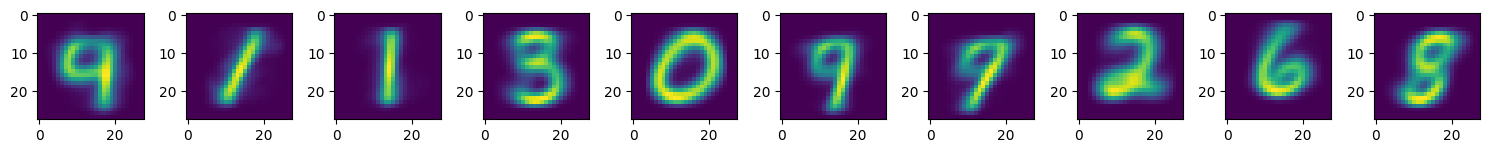

In [70]:
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, c in enumerate(centers):
    showim(c.reshape(1, -1), ax=axes[i])
plt.tight_layout()
plt.show()

In [71]:
cfae_cfs = []
amount = 10
print('starting cfae')
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        print('it: ' + str(i))
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=50, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))
print('starting ns')
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=amount)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

starting cfae
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
starting ns
Doing neighbor
Doing neighbor
Doing neighbor
Doing neighbor
Doing neighbor
Doing neighbor
Doing neighbor
Doing neighbor
Doing neighbor
Doing neighbor


/home/kvist/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kvist/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kvist/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kvist/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


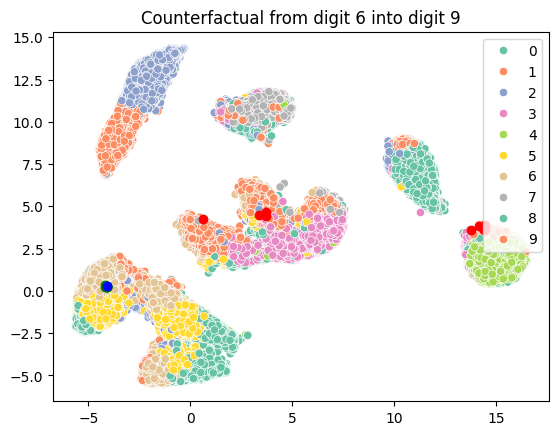

In [72]:
reducer = umap.UMAP()
embed_X = reducer.fit_transform(X)

cfae_embed = reducer.transform(cfae_cfs[0].cf)
ns_embed = reducer.transform(ns_cfs[0].cf)
instance = reducer.transform([X[cfae_cfs[0].instance]])
instance_label = cfae_cfs[0].instance_label
target_label = cfae_cfs[0].target

sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full',palette='Set2')
plt.scatter(cfae_embed[:,0],cfae_embed[:,1],color='green',label='CFAE')
plt.scatter(ns_embed[:,0],ns_embed[:,1],color='red',label='NeCS')
plt.scatter(instance[:,0],instance[:,1],color='blue',label='Instance')
plt.title(f"Counterfactual from digit {instance_label} into digit {target_label}")
plt.show()

instance


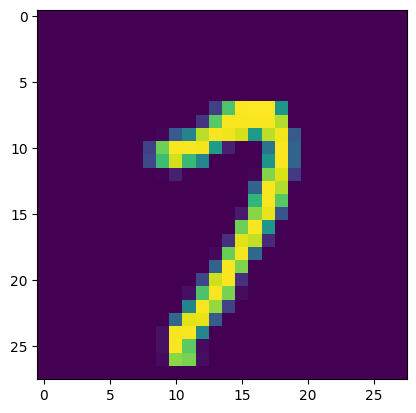

CFAE


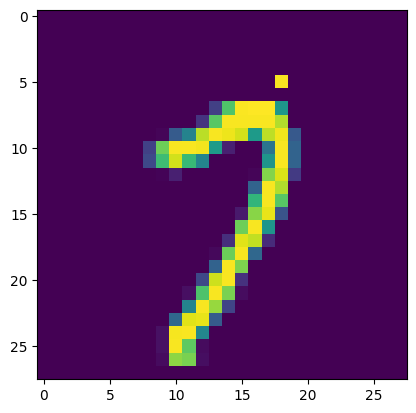

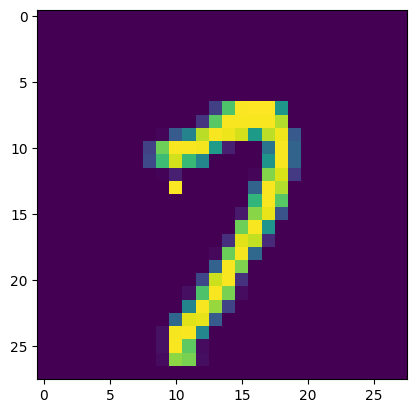

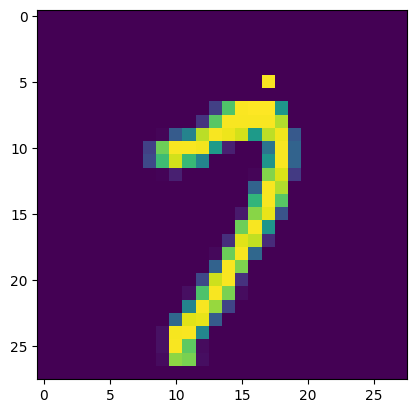

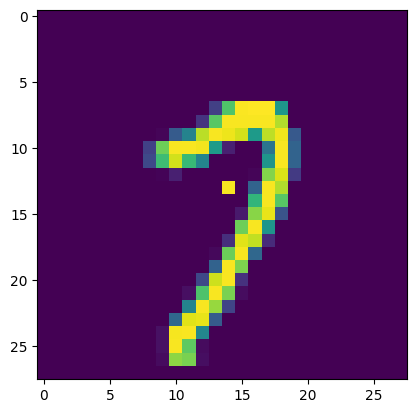

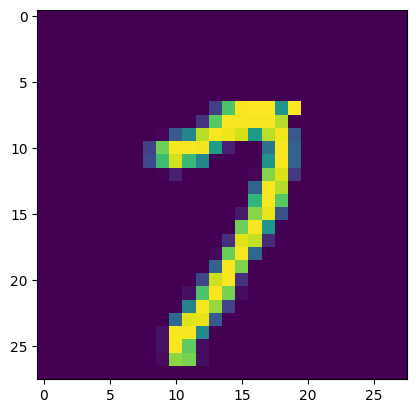

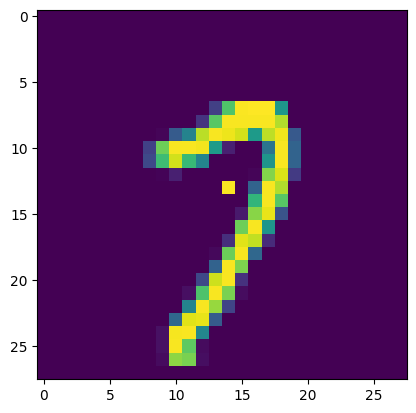

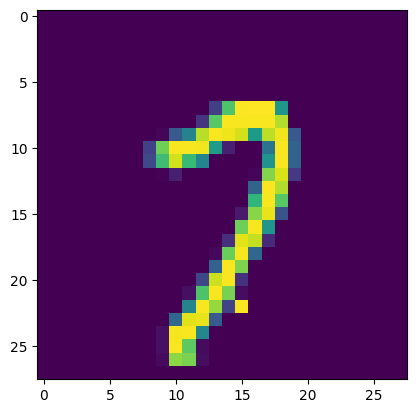

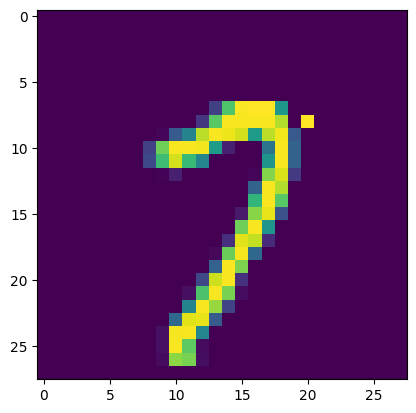

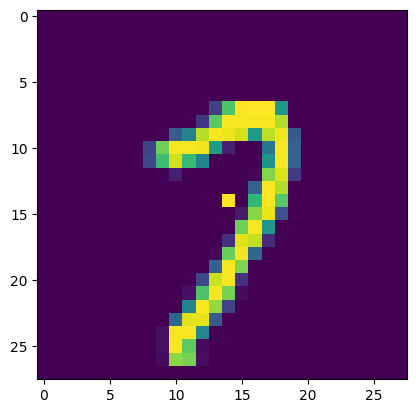

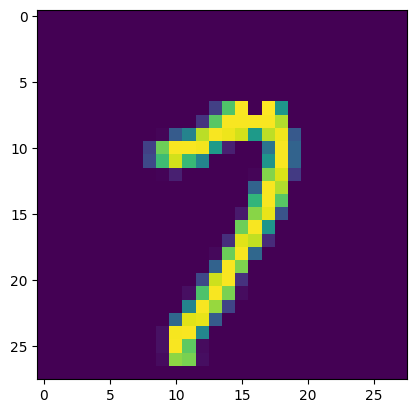

NeCS


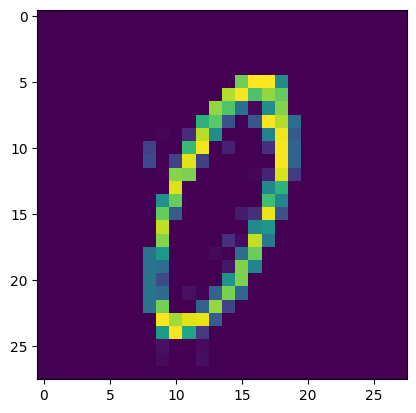

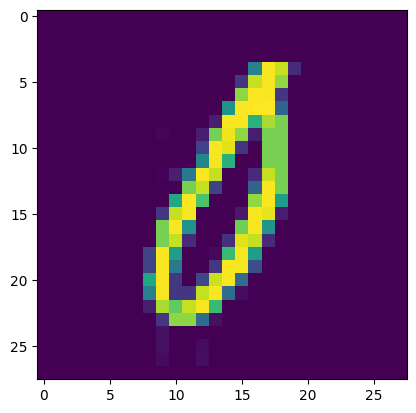

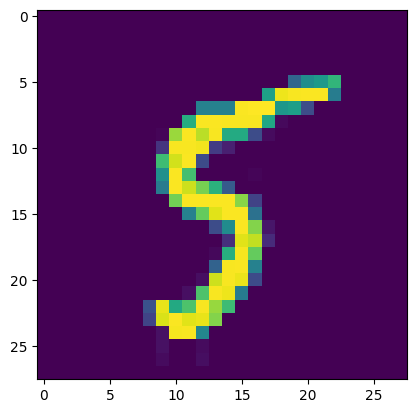

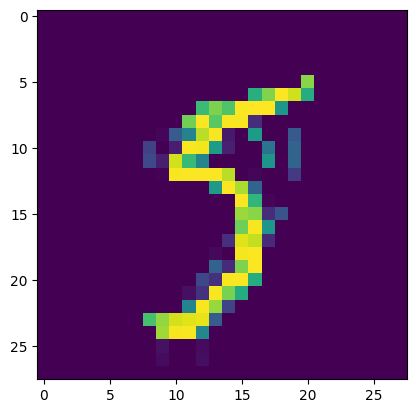

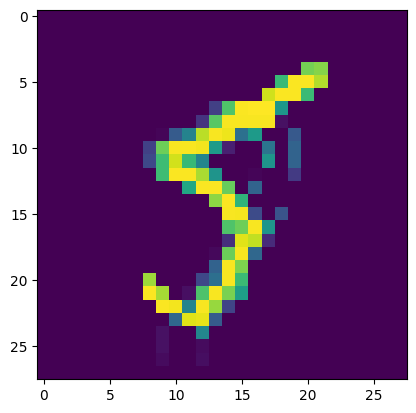

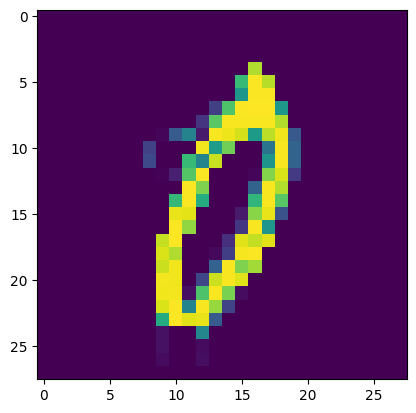

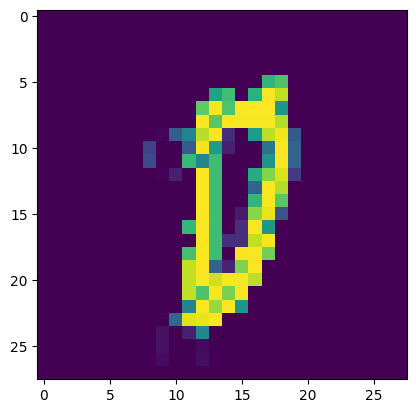

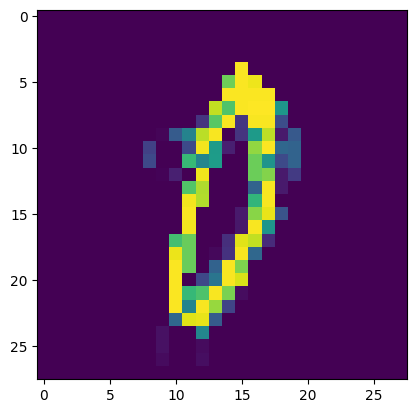

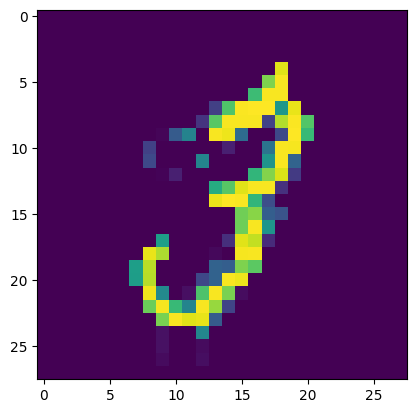

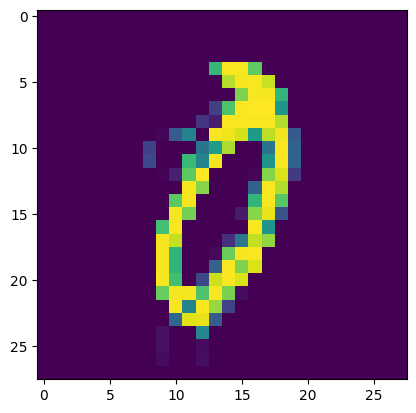

In [73]:
print('instance')
instance = X[cfae_cfs[0].instance]
showim([instance])

print('CFAE')
for pic in cfae_cfs[0].cf:
    showim([pic])

print('NeCS')
for pic in ns_cfs[0].cf:
    showim([pic])